# **Process the raw data**

The raw training images are 4D, here change it to 3D

In [1]:
import tifffile
import numpy as np
import os

tif_file_list = os.listdir('data/tiff_raw_data/')

if not os.path.exists('data/tiff_data/'):
    os.mkdir('data/tiff_data/')

for tif_file in tif_file_list:
    img = tifffile.imread('data/tiff_raw_data/' + tif_file)
    # print(img.shape)
    img = img.squeeze()
    # print(img.shape)
    tifffile.imwrite('data/tiff_data/' + tif_file, img)
    print(tif_file)


0.tif
1.tif
10.tif
100.tif
101.tif
102.tif
103.tif
104.tif
105.tif
106.tif
107.tif
108.tif
109.tif
11.tif
110.tif
111.tif
112.tif
113.tif
114.tif
115.tif
116.tif
117.tif
118.tif
119.tif
12.tif
120.tif
121.tif
122.tif
123.tif
124.tif
125.tif
126.tif
127.tif
128.tif
129.tif
13.tif
130.tif
131.tif
132.tif
133.tif
134.tif
135.tif
136.tif
137.tif
138.tif
139.tif
14.tif
140.tif
141.tif
142.tif
143.tif
144.tif
145.tif
146.tif
147.tif
148.tif
149.tif
15.tif
150.tif
151.tif
152.tif
153.tif
154.tif
155.tif
156.tif
157.tif
158.tif
159.tif
16.tif
160.tif
161.tif
162.tif
163.tif
164.tif
165.tif
166.tif
167.tif
168.tif
169.tif
17.tif
170.tif
171.tif
172.tif
173.tif
174.tif
175.tif
176.tif
177.tif
178.tif
179.tif
18.tif
19.tif
2.tif
20.tif
21.tif
22.tif
23.tif
24.tif
25.tif
26.tif
27.tif
28.tif
29.tif
3.tif
30.tif
31.tif
32.tif
33.tif
34.tif
35.tif
36.tif
37.tif
38.tif
39.tif
4.tif
40.tif
41.tif
42.tif
43.tif
44.tif
45.tif
46.tif
47.tif
48.tif
49.tif
5.tif
50.tif
51.tif
52.tif
53.tif
54.tif
55.tif
56

# **Get Mask through Cellpose**

In [ ]:
import os
import numpy as np

from cellpose import models, io

In [ ]:
file_list = os.listdir('data/Fluo-C2DL-Huh7/02')

if not os.path.exists('data/Fluo_mask_data'):
    os.mkdir('data/Fluo_mask_data')

model = models.Cellpose(gpu=True, model_type='cyto')

for file in file_list:
    if file.endswith('.tif'):
        print(file)
        
        img = io.imread('data/Fluo-C2DL-Huh7/02/' + file)
        print(img.shape)
        break
        masks, flows, styles, diams = model.eval(img, diameter=30, channels=[0,0])
        np.save('data/Fluo_mask_data/' + '02' + file[:-4] + '_mask.npy', masks)

t000.tif
(1024, 1024)


# **Generate single cell training data with mask**

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt

import cv2
import tifffile

In [ ]:
data_path = 'data/tiff_data/'
file_list = os.listdir(data_path)
mask_path = 'data/tiff_mask_data/'
save_path = 'data/single_cell_data_with_mask/'

bias = 3

if not os.path.exists(save_path):
    os.makedirs(save_path)

for file in file_list:
    filename = file.split('.')[0]
    print('Processing ' + file + '...')
    img = tifffile.imread(data_path + file)
    # print(img.shape)
    img = np.transpose(img, (2, 1, 0))
    mask = np.load(mask_path + '/' + filename + '_mask.npy')
    mask = np.transpose(mask, (1, 0))
    num_cells = np.max(mask.flatten())
    # plt.subplot(1, 2, 1)
    # plt.imshow(img[0], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(mask, cmap='gray')
    # plt.show()
    # print(min(mask.flatten()), max(mask.flatten()))
    print('Number of cells in ' + file + ': ' + str(num_cells))
    # break
    for i in range(1, num_cells + 1):
        cell_index = np.argwhere(mask == i)
        # print(cell_index.shape)
        x, y = cell_index[:, 1], cell_index[:, 0]
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        # print(x_min, x_max, y_min, y_max)
        if x_min < bias or x_max > img.shape[1] - bias or y_min < bias or y_max > img.shape[2] - bias:
            print('Cell ' + str(i) + ' in ' + file + ' is too close to the edge!')
            continue
        cell = img[:, y_min-bias:y_max+bias, x_min-bias:x_max+bias]
        # if i == 2:
        #     plt.subplot(1, 2, 1)
        #     plt.imshow(img.)
            # print(cell.shape)
        if (np.count_nonzero(cell[0]) / (cell.shape[1]*cell.shape[2])) < 0.5:
            print('Empty cell!')
            continue
        tifffile.imsave(save_path + filename + '_' + str(i) + '.tif', cell)
        mask_cell = np.zeros(mask.shape)
        # print(cell_index.shape, mask_cell.shape)
        mask_cell[mask == i] = 1
        mask_cell = mask_cell[y_min-bias:y_max+bias, x_min-bias:x_max+bias]
        # mask_cell[mask_cell != i] = 0
        mask_cell = mask_cell.astype(np.uint8)
        tifffile.imsave(save_path + filename + '_' + str(i) + '_mask.tif', mask_cell)
        print('Cell ' + str(i) + ' in ' + file + ' saved!')
        # if i == 15:
        #     # print(cell.shape, mask_cell.shape)
        #     # print(mask_cell[:, :])
        #     plt.subplot(1, 2, 1)
        #     plt.imshow(cell[0])
        #     plt.subplot(1, 2, 2)
        #     plt.imshow(mask_cell[:, :])
        #     plt.show()
    #         break
    # break
        # np.save(save_path + '/' + filename + '_' + str(i) + '.npy', cell)

Processing 0.tif...
Number of cells in 0.tif: 158
Cell 1 in 0.tif is too close to the edge!
Cell 2 in 0.tif saved!
Cell 3 in 0.tif saved!
Cell 4 in 0.tif saved!
Cell 5 in 0.tif saved!
Cell 6 in 0.tif saved!
Cell 7 in 0.tif saved!
Cell 8 in 0.tif saved!
Cell 9 in 0.tif saved!
Cell 10 in 0.tif saved!
Cell 11 in 0.tif saved!
Cell 12 in 0.tif saved!
Cell 13 in 0.tif saved!
Cell 14 in 0.tif saved!
Cell 15 in 0.tif saved!
Cell 16 in 0.tif saved!
Cell 17 in 0.tif saved!
Cell 18 in 0.tif saved!
Cell 19 in 0.tif saved!
Cell 20 in 0.tif saved!
Cell 21 in 0.tif saved!
Cell 22 in 0.tif saved!
Cell 23 in 0.tif saved!
Cell 24 in 0.tif saved!
Cell 25 in 0.tif saved!
Cell 26 in 0.tif saved!
Cell 27 in 0.tif saved!
Cell 28 in 0.tif saved!
Cell 29 in 0.tif saved!
Cell 30 in 0.tif saved!
Cell 31 in 0.tif saved!
Cell 32 in 0.tif saved!
Cell 33 in 0.tif saved!
Cell 34 in 0.tif saved!
Cell 35 in 0.tif saved!


C:\Users\hx57\AppData\Local\Temp\ipykernel_29556\1989504745.py:46: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(save_path + filename + '_' + str(i) + '.tif', cell)
C:\Users\hx57\AppData\Local\Temp\ipykernel_29556\1989504745.py:53: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(save_path + filename + '_' + str(i) + '_mask.tif', mask_cell)


Cell 36 in 0.tif saved!
Cell 37 in 0.tif saved!
Cell 38 in 0.tif saved!
Cell 39 in 0.tif saved!
Cell 40 in 0.tif saved!
Cell 41 in 0.tif saved!
Cell 42 in 0.tif saved!
Cell 43 in 0.tif saved!
Cell 44 in 0.tif saved!
Cell 45 in 0.tif saved!
Cell 46 in 0.tif saved!
Cell 47 in 0.tif saved!
Cell 48 in 0.tif saved!
Cell 49 in 0.tif saved!
Cell 50 in 0.tif saved!
Cell 51 in 0.tif saved!
Cell 52 in 0.tif saved!
Cell 53 in 0.tif saved!
Cell 54 in 0.tif saved!
Cell 55 in 0.tif saved!
Cell 56 in 0.tif saved!
Cell 57 in 0.tif saved!
Cell 58 in 0.tif saved!
Cell 59 in 0.tif saved!
Cell 60 in 0.tif saved!
Cell 61 in 0.tif saved!
Cell 62 in 0.tif saved!
Cell 63 in 0.tif saved!
Cell 64 in 0.tif saved!
Cell 65 in 0.tif saved!
Cell 66 in 0.tif saved!
Cell 67 in 0.tif saved!
Cell 68 in 0.tif saved!
Cell 69 in 0.tif saved!
Cell 70 in 0.tif saved!
Cell 71 in 0.tif saved!
Cell 72 in 0.tif saved!
Cell 73 in 0.tif saved!
Cell 74 in 0.tif saved!
Cell 75 in 0.tif saved!
Cell 76 in 0.tif saved!
Cell 77 in 0.tif

# **Calculate mean and std of dataset**

In [2]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt

data_path = 'data/single_cell_data/'

In [ ]:
file_list = os.listdir(data_path)

# mean_tmpt, std_tmpt = [], []
# mean, std = [], []

# for i in range(4):
#     for file in file_list:
#         if file.endswith('.tif'):
#             img = tifffile.imread(data_path + file)
#             mean_tmpt.append(np.mean(img[i]))
#             std_tmpt.append(np.std(img[i]))
#     mean.append(np.mean(mean_tmpt))
#     std.append(np.mean(std_tmpt))
#     mean_tmpt, std_tmpt = [], []

# print(mean)
# print(std)

[6076.685883679818, 1350.9691095158794, 5090.145564947434, 5019.978020658786]
[5504.395544161098, 1145.6356702621574, 663.3312283427825, 706.0040270727409]


In [3]:
mean = np.array([6076.685883679818, 1350.9691095158794, 5090.145564947434, 5019.978020658786])
std = np.array([5504.395544161098, 1145.6356702621574, 663.3312283427825, 706.0040270727409])

(4, 22, 19)


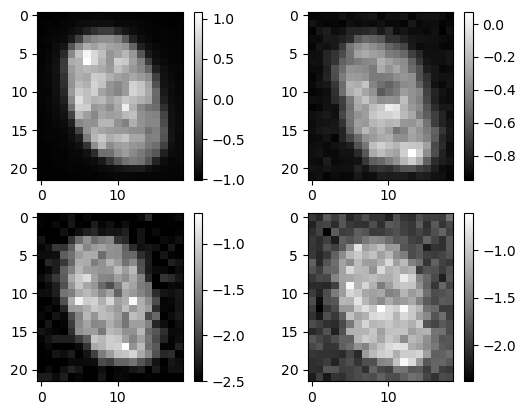

In [15]:
data_path = 'data/single_cell_data/'

file_list = os.listdir(data_path)

idx = 0

img = tifffile.imread(data_path + file_list[idx])
print(img.shape)

img = img.astype(np.float32)

for i in range(4):
    img[i] = (img[i] - mean[i]) / std[i]
# img = (img - mean) / std


fig = plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(img[0], cmap='gray')
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(img[1], cmap='gray')
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(img[2], cmap='gray', vmin=-2.5)
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(img[3], cmap='gray')
plt.colorbar()
plt.show()

(array([  5.,  56., 148.,  39.,  18.,  31.,  53.,  51.,  14.,   3.]),
 array([-2.97912335, -2.74786639, -2.51660919, -2.28535223, -2.05409527,
        -1.82283831, -1.59158123, -1.36032414, -1.12906718, -0.89781016,
        -0.66655314]),
 <BarContainer object of 10 artists>)

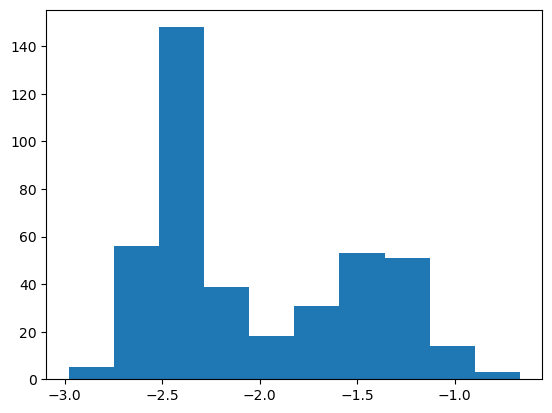

In [12]:
plt.hist((img[2]).flatten())

# **look at the histogram of each channel**

In [1]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt

data_path = 'data/single_cell_data/'

In [2]:
file_list = os.listdir(data_path)
img_stack = [None, None, None, None]

for i in range(4):
    for idx, file in enumerate(file_list):
        if file.endswith('.tif'):
            img = tifffile.imread(data_path + file)
            if idx == 0:
                img_stack[i] = img[i].flatten()
            else:
                img_stack[i] = np.hstack((img_stack[i], img[i].flatten()))

In [4]:
img_stack[0].shape

(30434551,)

([<matplotlib.axis.XTick at 0x296b6164a60>,
 [Text(200, 0, '200'),
  Text(1000, 0, '1000'),
  Text(1800, 0, '1800'),
  Text(2600, 0, '2600'),
  Text(3400, 0, '3400'),
  Text(4200, 0, '4200'),
  Text(5000, 0, '5000'),
  Text(5800, 0, '5800'),
  Text(6600, 0, '6600'),
  Text(7400, 0, '7400'),
  Text(8200, 0, '8200'),
  Text(9000, 0, '9000'),
  Text(9800, 0, '9800'),
  Text(10600, 0, '10600'),
  Text(11400, 0, '11400'),
  Text(12200, 0, '12200'),
  Text(13000, 0, '13000'),
  Text(13800, 0, '13800'),
  Text(14600, 0, '14600'),
  Text(15400, 0, '15400'),
  Text(16200, 0, '16200'),
  Text(17000, 0, '17000'),
  Text(17800, 0, '17800'),
  Text(18600, 0, '18600'),
  Text(19400, 0, '19400'),
  Text(20200, 0, '20200'),
  Text(21000, 0, '21000'),
  Text(21800, 0, '21800'),
  Text(22600, 0, '22600'),
  Text(23400, 0, '23400'),
  Text(24200, 0, '24200'),
  Text(25000, 0, '25000'),
  Text(25800, 0, '25800'),
  Text(26600, 0, '26600'),
  Text(27400, 0, '27400'),
  Text(28200, 0, '28200')])

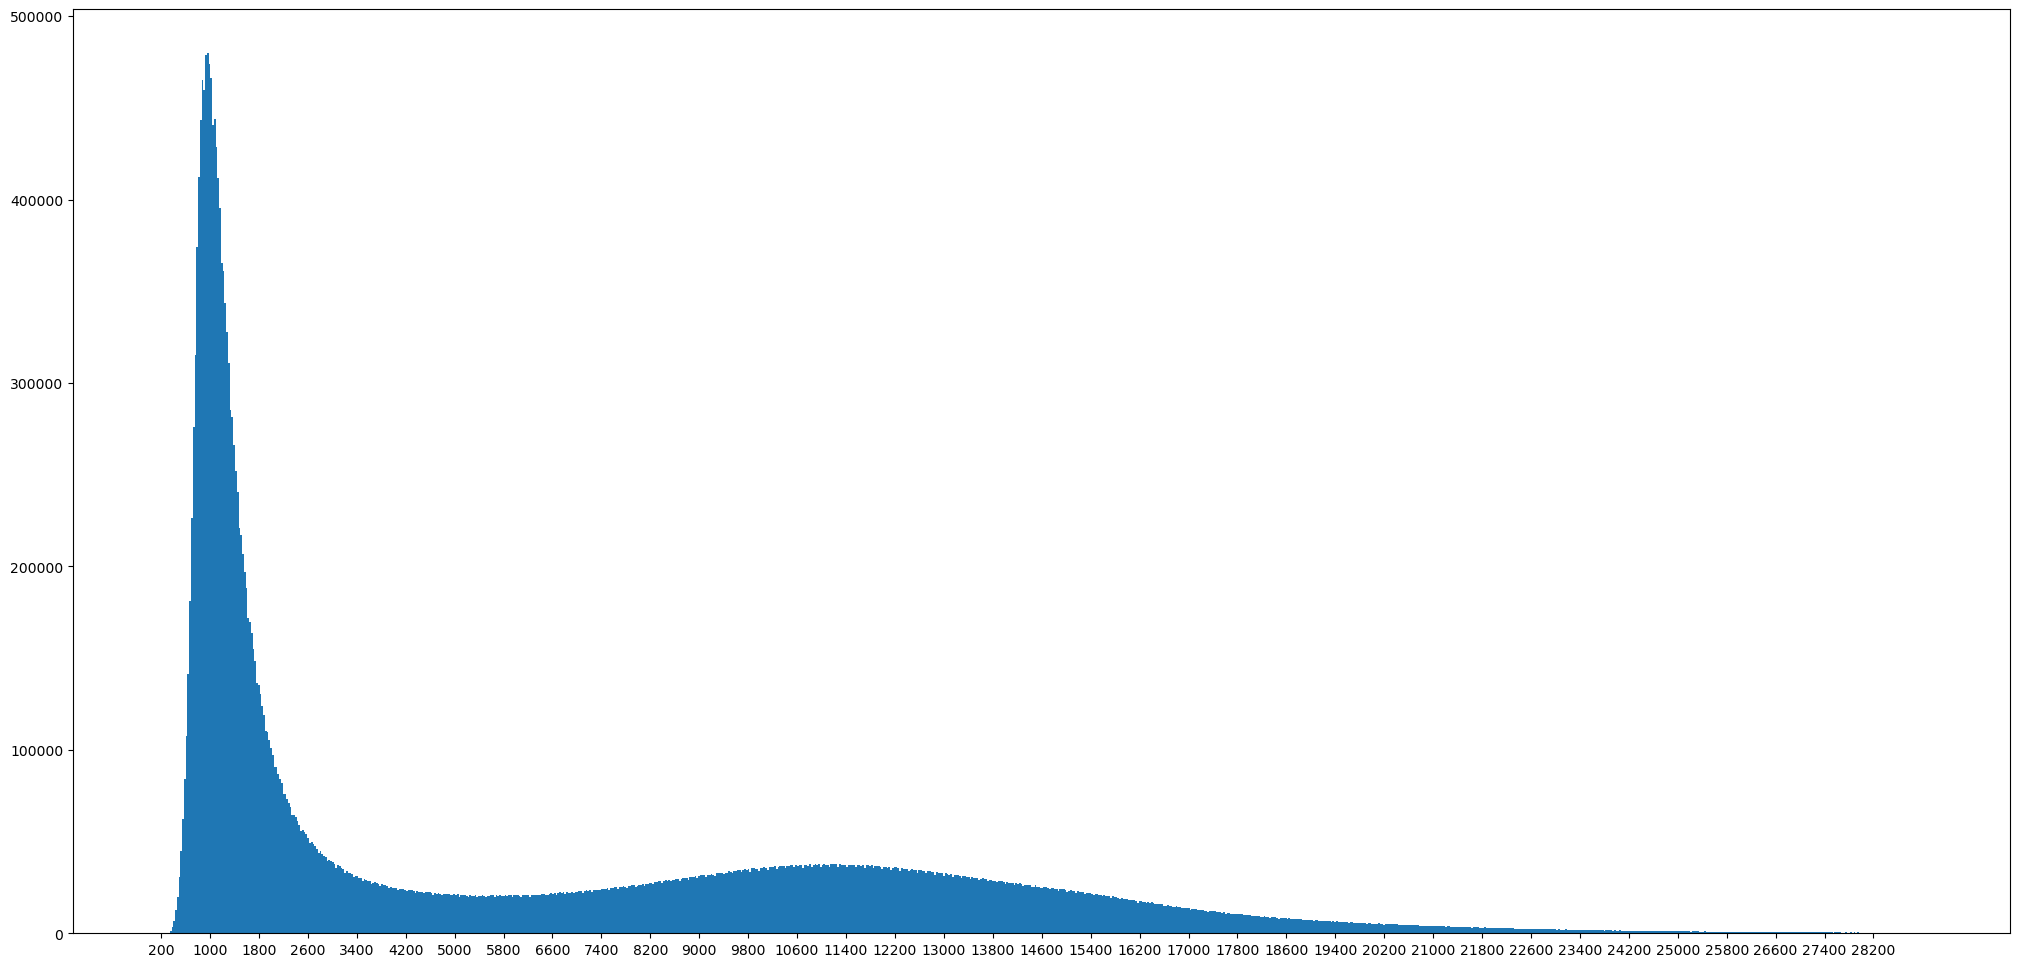

In [106]:
import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator

# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# ax.xaxis.set_major_locator(MultipleLocator(5000))
# ax.xaxis.set_minor_locator(MultipleLocator(1000))

plt.figure(figsize=(25, 12))
plt.hist(img_stack[0], bins=1000, range=(200, 29000))
plt.xticks(np.arange(200, 29000, 800))

([<matplotlib.axis.XTick at 0x2968b246460>,
 [Text(0, 0, '0'),
  Text(300, 0, '300'),
  Text(600, 0, '600'),
  Text(900, 0, '900'),
  Text(1200, 0, '1200'),
  Text(1500, 0, '1500'),
  Text(1800, 0, '1800'),
  Text(2100, 0, '2100'),
  Text(2400, 0, '2400'),
  Text(2700, 0, '2700'),
  Text(3000, 0, '3000'),
  Text(3300, 0, '3300'),
  Text(3600, 0, '3600'),
  Text(3900, 0, '3900'),
  Text(4200, 0, '4200'),
  Text(4500, 0, '4500'),
  Text(4800, 0, '4800'),
  Text(5100, 0, '5100'),
  Text(5400, 0, '5400'),
  Text(5700, 0, '5700'),
  Text(6000, 0, '6000'),
  Text(6300, 0, '6300'),
  Text(6600, 0, '6600'),
  Text(6900, 0, '6900'),
  Text(7200, 0, '7200'),
  Text(7500, 0, '7500'),
  Text(7800, 0, '7800'),
  Text(8100, 0, '8100'),
  Text(8400, 0, '8400'),
  Text(8700, 0, '8700'),
  Text(9000, 0, '9000'),
  Text(9300, 0, '9300'),
  Text(9600, 0, '9600'),
  Text(9900, 0, '9900'),
  Text(10200, 0, '10200'),
  Text(10500, 0, '10500'),
  Text(10800, 0, '10800'),
  Text(11100, 0, '11100'),
  Text(114

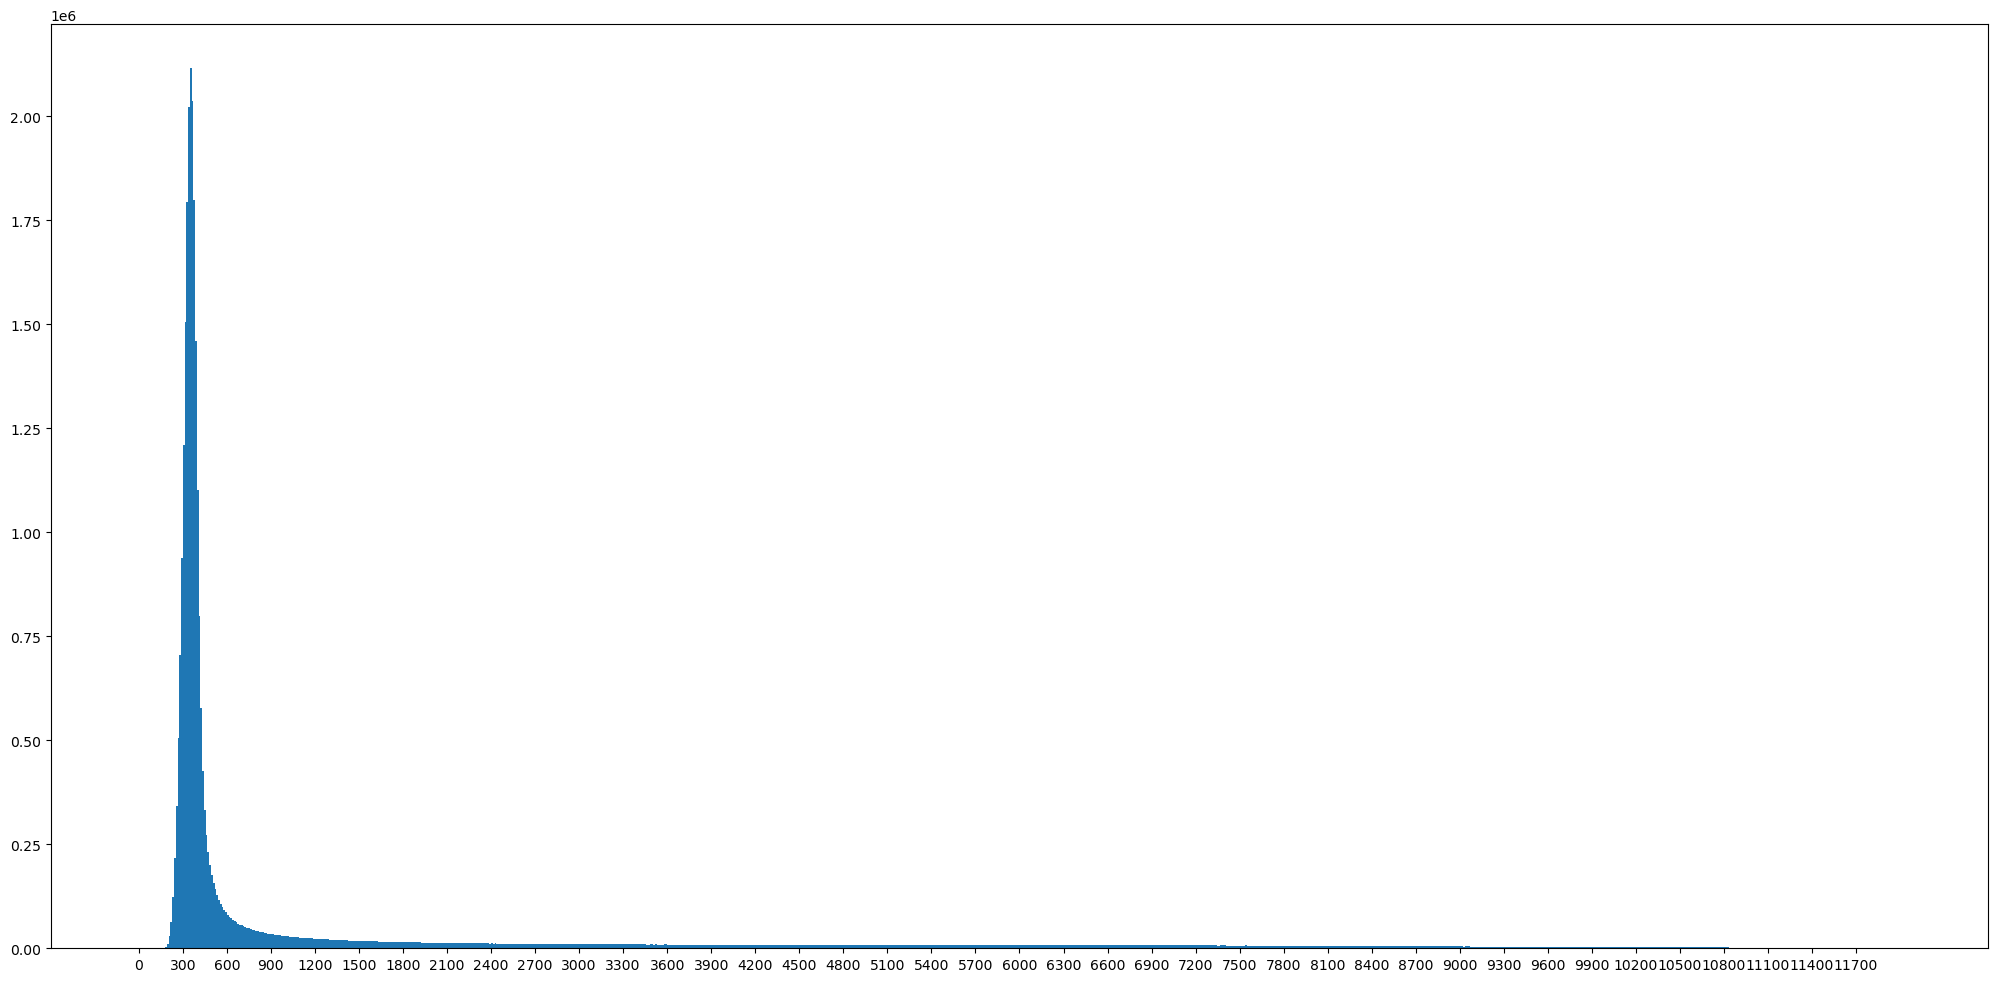

In [66]:
plt.figure(figsize=(25, 12))
plt.hist(img_stack[1], bins=1000, range=(0, 12000))
plt.xticks(np.arange(0, 12000, 300))

([<matplotlib.axis.XTick at 0x2969fb044c0>,
 [Text(1800, 0, '1800'),
  Text(2100, 0, '2100'),
  Text(2400, 0, '2400'),
  Text(2700, 0, '2700'),
  Text(3000, 0, '3000'),
  Text(3300, 0, '3300'),
  Text(3600, 0, '3600'),
  Text(3900, 0, '3900'),
  Text(4200, 0, '4200'),
  Text(4500, 0, '4500'),
  Text(4800, 0, '4800'),
  Text(5100, 0, '5100'),
  Text(5400, 0, '5400'),
  Text(5700, 0, '5700'),
  Text(6000, 0, '6000'),
  Text(6300, 0, '6300'),
  Text(6600, 0, '6600'),
  Text(6900, 0, '6900'),
  Text(7200, 0, '7200'),
  Text(7500, 0, '7500'),
  Text(7800, 0, '7800'),
  Text(8100, 0, '8100'),
  Text(8400, 0, '8400'),
  Text(8700, 0, '8700'),
  Text(9000, 0, '9000'),
  Text(9300, 0, '9300'),
  Text(9600, 0, '9600'),
  Text(9900, 0, '9900'),
  Text(10200, 0, '10200'),
  Text(10500, 0, '10500'),
  Text(10800, 0, '10800'),
  Text(11100, 0, '11100'),
  Text(11400, 0, '11400'),
  Text(11700, 0, '11700'),
  Text(12000, 0, '12000'),
  Text(12300, 0, '12300'),
  Text(12600, 0, '12600'),
  Text(12900,

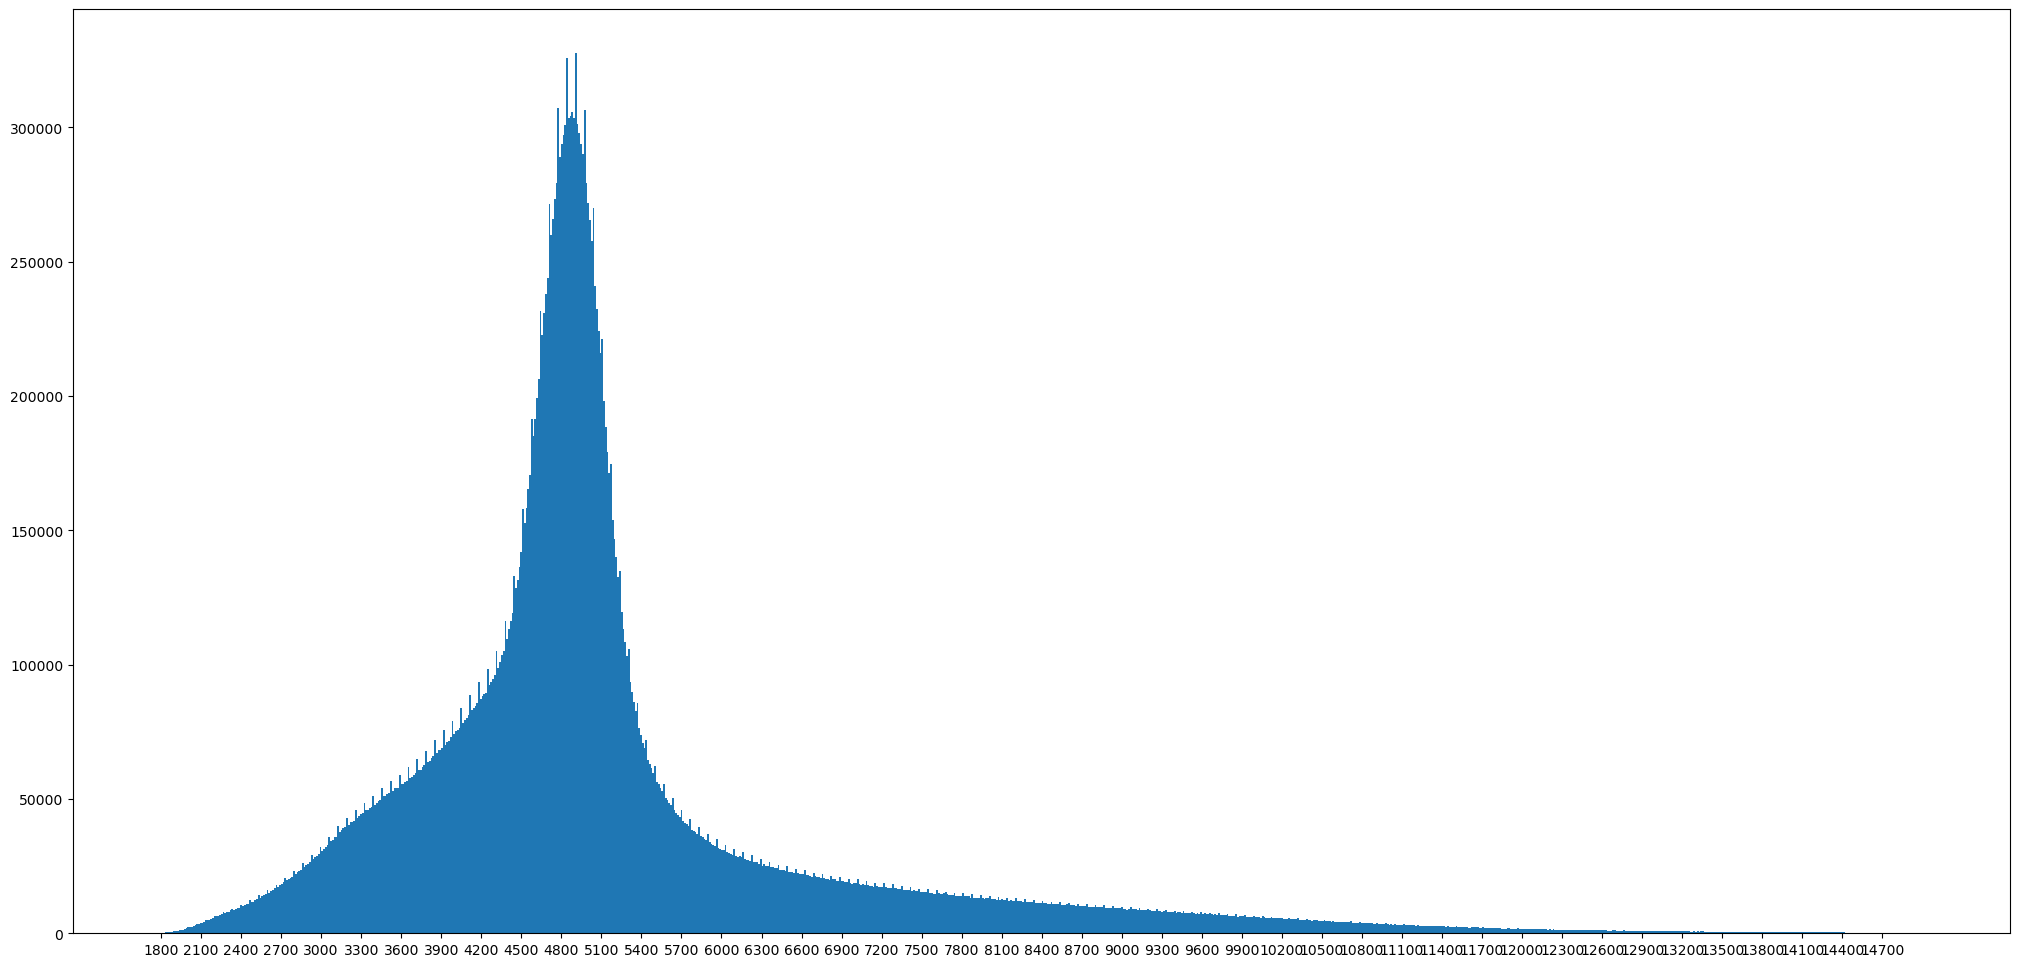

In [82]:
plt.figure(figsize=(25, 12))
plt.hist(img_stack[2], bins=1000, range=(1800, 15000))
plt.xticks(np.arange(1800, 15000, 300))

([<matplotlib.axis.XTick at 0x296b09ad820>,
 [Text(1800, 0, '1800'),
  Text(2100, 0, '2100'),
  Text(2400, 0, '2400'),
  Text(2700, 0, '2700'),
  Text(3000, 0, '3000'),
  Text(3300, 0, '3300'),
  Text(3600, 0, '3600'),
  Text(3900, 0, '3900'),
  Text(4200, 0, '4200'),
  Text(4500, 0, '4500'),
  Text(4800, 0, '4800'),
  Text(5100, 0, '5100'),
  Text(5400, 0, '5400'),
  Text(5700, 0, '5700'),
  Text(6000, 0, '6000'),
  Text(6300, 0, '6300'),
  Text(6600, 0, '6600'),
  Text(6900, 0, '6900'),
  Text(7200, 0, '7200'),
  Text(7500, 0, '7500'),
  Text(7800, 0, '7800'),
  Text(8100, 0, '8100'),
  Text(8400, 0, '8400'),
  Text(8700, 0, '8700'),
  Text(9000, 0, '9000'),
  Text(9300, 0, '9300'),
  Text(9600, 0, '9600'),
  Text(9900, 0, '9900'),
  Text(10200, 0, '10200'),
  Text(10500, 0, '10500'),
  Text(10800, 0, '10800'),
  Text(11100, 0, '11100'),
  Text(11400, 0, '11400'),
  Text(11700, 0, '11700')])

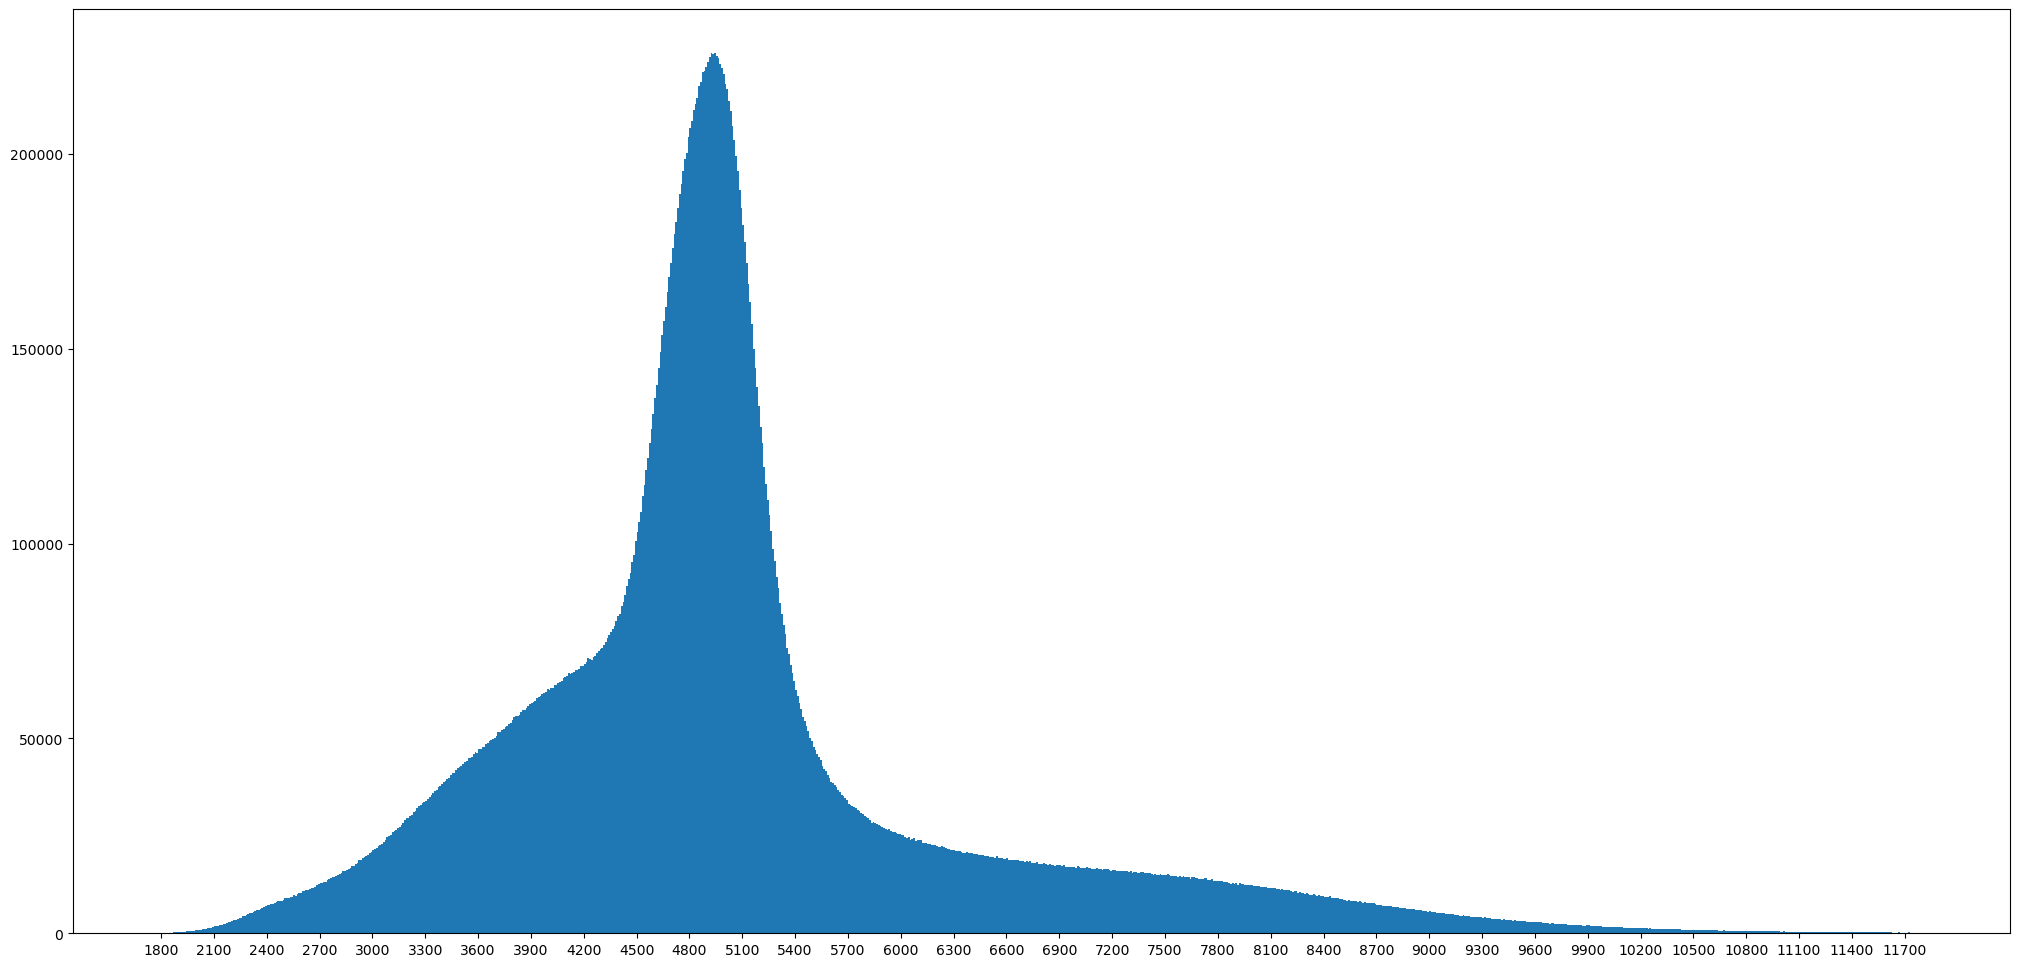

In [95]:
plt.figure(figsize=(25, 12))
plt.hist(img_stack[3], bins=1000, range=(1800, 11800))
plt.xticks(np.arange(1800, 11800, 300))

# **Do clamp the data to a reasonable range and re-calculate mean and std**

In [1]:
import os
import tifffile
import numpy as np

import matplotlib.pyplot as plt

data_path = 'data/single_cell_data/'

In [2]:
file_list = os.listdir(data_path)

mean_tmpt, std_tmpt = [], []
mean, std = [], []

for idx, file in enumerate(file_list):
    if file.endswith('.tif'):
        img = tifffile.imread(data_path + file)
        img[0] = np.clip(img[0], 300, 28000)
        img[1] = np.clip(img[1], 180, 10800)
        img[2] = np.clip(img[2], 1800, 14400)
        img[3] = np.clip(img[3], 1800, 11800)
        mean.append(np.mean(img, axis=(1, 2)))
        std.append(np.std(img, axis=(1, 2)))
        # print(img.shape)
        # if idx == 10:
        #     break

    # mean.append(np.mean(mean_tmpt))
    # std.append(np.mean(std_tmpt))
    # mean_tmpt, std_tmpt = [], []

# print(mean)
# print(std)
mean = np.array(mean)
std = np.array(std)
print(mean.shape, std.shape)
print(np.mean(mean, axis=0))
print(np.mean(std, axis=0))

(75568, 4) (75568, 4)
[6071.00008939 1333.11164146 5088.6889315  5019.25101443]
[5493.51552474 1109.11673063  660.90377311  704.11820438]


raw mean: [6076.685883679818, 1350.9691095158794, 5090.145564947434, 5019.978020658786]

new mean: [6071.00008939, 1333.11164146, 5088.6889315, 5019.25101443]

raw std: [5504.395544161098, 1145.6356702621574, 663.3312283427825, 706.0040270727409]

new std: [5493.51552474, 1109.11673063, 660.90377311, 704.11820438]

|       | channel 1 | channel 2 | channel 3 | channel 4 |
|-------|-------|-------|-------|-------|
| raw mean | 6076.685883679818 | 1350.9691095158794 | 5090.145564947434 | 5019.978020658786 |
| new mean | 6071.00008939 | 1333.11164146 | 5088.6889315 | 5019.25101443 |
| raw std | 5504.395544161098 | 1145.6356702621574 | 663.3312283427825 | 706.0040270727409 |
| new std | 5493.51552474 | 1109.11673063 | 660.90377311 | 704.11820438 |